# Projet : inpainting

Ariana CARNIELLI &mdash; 3525837

In [2]:
import importlib
import matplotlib.pyplot as plt
import numpy as np
import utils
import utils_preambule as ut_p

from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.multiclass import OneVsRestClassifier, OneVsOneClassifier
from sklearn.model_selection import GridSearchCV

%matplotlib notebook

## 1. Préambule : régression linéaire, régression ridge et LASSO

Dans cette partie, on compare les régressions linéaire, ridge et LASSO sur la base de données USPS de classification de chiffres manuscrits. Pour cela, on utilise les regressions linéaires `LinearRegression`, `Ridge` et `Lasso` implémentées sur `sklearn.linear_model`. On rappelle que les régressions linéaire et de ridge ont été implémentées dans le TME 3, mais on a choisi d'utiliser les classes déjà implémentées par `sklearn` car elles contiennent des optimisations qui n'ont pas été implémentées lors de ce TME et tournent ainsi plus vite.

Les classes `LinearRegression`, `Ridge` et `Lasso` permettent, à l'aide de l'argument `normalize` de leurs constructeurs, de normaliser les données d'entrée en soustrayant la moyenne et divisant par l'écart-type de chaque colonne du dataset d'apprentissage. On a choisi de le faire, en mettant `normalize` à `True`, dans tous les tests présentés dans cette partie.

Comme il s'agit d'un problème de classification multi-classes, il faut aussi utiliser les méthodes de classification multi-classes. Comme indiqué ci-dessous (voir Section 1.1), on a rencontré des problèmes avec le `OneVsOneClassifier` du module `sklearn.multiclass` et, ainsi, on a utilisé les classes `OvA` et `OvO` codées au TME 4, compris dans le fichiers `utils_preambule.py`.

On commence par charger la base de données USPS.

In [2]:
trainX, trainY = ut_p.load_usps("USPS_train.txt")    
testX, testY = ut_p.load_usps("USPS_test.txt")

Les régressions rigde et LASSO dépendent chacune d'un paramètre $\alpha$, qui représente le poids donné à la norme 1 ou 2 dans la fonction à minimiser. Afin de trouver la meilleure valeur de $\alpha$ dans chacun des cas, on utilise l'optimisation d'hyper-paramètres `GridSearchCV` de `sklearn.model_selection` (comme dans le TME 4). Pour cela, il a fallu adapter les classes `OvA` et `OvO`, en codant les méthodes `get_params` et `set_params`, afin qu'elles deviennent compatibles avec `GridSearchCV`.

On a quatre valeurs de $\alpha$ à estimer :

- Une valeur pour `Ridge` avec le `OvA`
- Une valeur pour `Ridge` avec le `OvO`
- Une valeur pour `Lasso` avec le `OvA`
- Une valeur pour `Lasso` avec le `OvO`

On commence alors par chercher ces meilleurs valeurs de $\alpha$ à l'aide de la base d'apprentissage. Comme les valeurs de $\alpha$ optimales trouvées sont d'ordres de grandeur différentes, on a choisi des grilles de recherche différentes à chaque fois (en trouvant d'abord l'ordre de grandeur de chaque $\alpha$ empiriquement avec des tests).

In [4]:
bestParams = {}
grids = {(Ridge, ut_p.OvA): np.logspace(-2, -1, 10),\
         (Ridge, ut_p.OvO): np.logspace(-1,  0, 10),\
         (Lasso, ut_p.OvA): np.logspace(-6.5, -5.5, 10),\
         (Lasso, ut_p.OvO): np.logspace(-4.1, -3.1, 10)}
for est in [Ridge, Lasso]:
    for cla in [ut_p.OvA, ut_p.OvO]:
        bestParams[(est, cla)] = GridSearchCV(cla(est, 10, normalize = True),\
                                              {'alpha': grids[(est, cla)]})
        bestParams[(est, cla)].fit(trainX, trainY)
        print("Meilleur alpha pour ({}, {}): {}".format(est.__name__, cla.__name__,\
                                                        bestParams[(est, cla)].best_params_['alpha']))


Meilleur alpha pour (Ridge, OvA): 0.0774263682681127
Meilleur alpha pour (Ridge, OvO): 0.1291549665014884
Meilleur alpha pour (Lasso, OvA): 8.799225435691074e-07
Meilleur alpha pour (Lasso, OvO): 0.00010259143654700108


Une fois les meilleurs $\alpha$ calculés, on implémente les classificateurs multi-classes.

In [12]:
classifiers = {}
for est in [LinearRegression, Ridge, Lasso]:
    for cla in [ut_p.OvA, ut_p.OvO]:
        if (est, cla) in bestParams:
            classifiers[(est, cla)] = cla(est, 10, normalize = True,\
                                          alpha = bestParams[(est, cla)].best_params_['alpha'])
        else:
            classifiers[(est, cla)] = cla(est, 10, normalize = True)
        classifiers[(est, cla)].fit(trainX, trainY)

Dans un premier temps, on regarde les résultats de chaque classification en apprentissage et en test.

In [13]:
print("+--------------------+-----------+-----------+")
print("| Train              | OvA       | OvO       |")
print("+--------------------+-----------+-----------+")
for est in [LinearRegression, Ridge, Lasso]:
    print("| {:18s} | ".format(est.__name__), end="")
    for cla in [ut_p.OvA, ut_p.OvO]:
        print("   {:6.4f} | ".format(classifiers[(est, cla)].score(trainX, trainY)), end="")
    print("")
print("+--------------------+-----------+-----------+")

print("+--------------------+-----------+-----------+")
print("| Test               | OvA       | OvO       |")
print("+--------------------+-----------+-----------+")
for est in [LinearRegression, Ridge, Lasso]:
    print("| {:18s} | ".format(est.__name__), end="")
    for cla in [ut_p.OvA, ut_p.OvO]:
        print("   {:6.4f} | ".format(classifiers[(est, cla)].score(testX, testY)), end="")
    print("")
print("+--------------------+-----------+-----------+")

+--------------------+-----------+-----------+
| Train              | OvA       | OvO       |
+--------------------+-----------+-----------+
| LinearRegression   |    0.9240 |    0.9841 | 
| Ridge              |    0.9209 |    0.9770 | 
| Lasso              |    0.9240 |    0.9763 | 
+--------------------+-----------+-----------+
+--------------------+-----------+-----------+
| Test               | OvA       | OvO       |
+--------------------+-----------+-----------+
| LinearRegression   |    0.8695 |    0.9118 | 
| Ridge              |    0.8764 |    0.9258 | 
| Lasso              |    0.8710 |    0.9203 | 
+--------------------+-----------+-----------+


Avec les bons taux de classification en apprentissage et en test des classifieurs précédents, on procède à la comparaison de leurs vecteurs `w`.

<IPython.core.display.Javascript object>


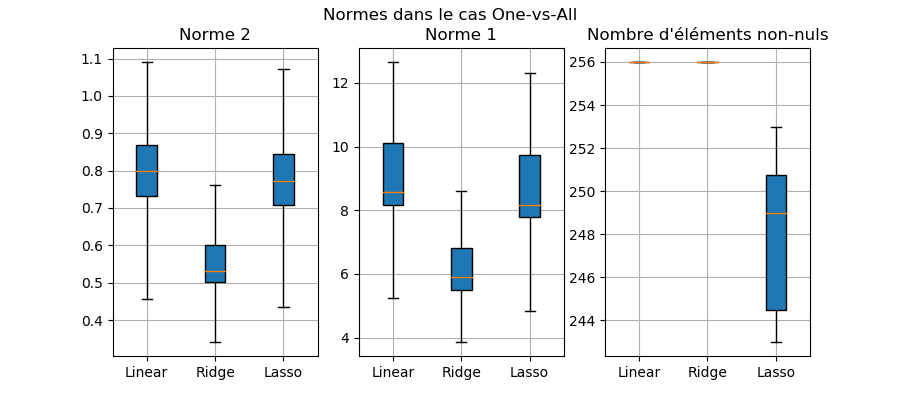

<IPython.core.display.Javascript object>


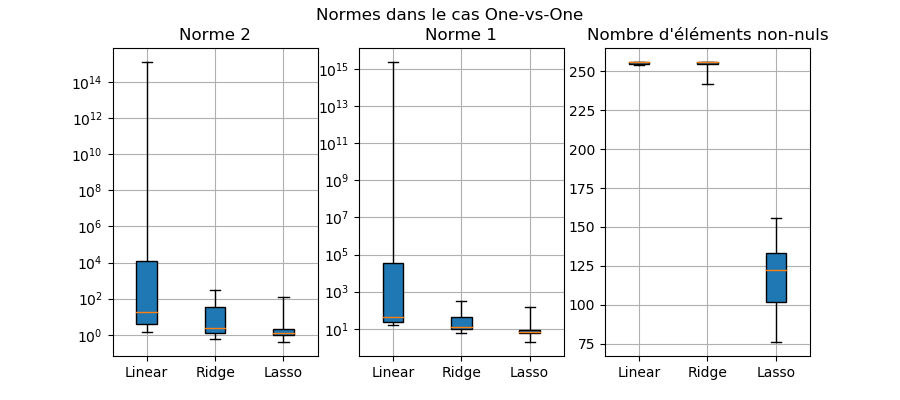

In [15]:
# Dictionnaires qui contiendront les normes 2 et 1 et la quantité d'éléments non-nuls de w.
wNorm2 = {}
wNorm1 = {}
wNonNul = {}

# Remplissage des dictionnaires
# Comme ut_p.OvA et ut_p.OvO stockent les classifieurs internes de façons différentes (tableau numpy pour le 
# premier, dictionnaire pour le deuxième), les deux cas sont traités de façon séparée
for est in [LinearRegression, Ridge, Lasso]:
    cl = classifiers[(est, ut_p.OvA)]
    wNorm2[(est, ut_p.OvA)] = np.array([np.linalg.norm(c.coef_, 2) for c in cl.classifiers])
    wNorm1[(est, ut_p.OvA)] = np.array([np.linalg.norm(c.coef_, 1) for c in cl.classifiers])
    wNonNul[(est, ut_p.OvA)] = np.array([np.linalg.norm(c.coef_, 0) for c in cl.classifiers])
    
    cl = classifiers[(est, ut_p.OvO)]
    wNorm2[(est, ut_p.OvO)] = np.array([np.linalg.norm(c.coef_, 2) for c in cl.classifiers.values()])
    wNorm1[(est, ut_p.OvO)] = np.array([np.linalg.norm(c.coef_, 1) for c in cl.classifiers.values()])
    wNonNul[(est, ut_p.OvO)] = np.array([np.linalg.norm(c.coef_, 0) for c in cl.classifiers.values()])

# Affichage pour OvA
fig, ax = plt.subplots(1, 3, figsize=(9, 4))
for i, w in enumerate([wNorm2, wNorm1, wNonNul]):
    ax[i].boxplot([w[(m, ut_p.OvA)] for m in [LinearRegression, Ridge, Lasso]], whis='range', patch_artist = True)
    ax[i].set_xticklabels(["Linear", "Ridge", "Lasso"])
    ax[i].grid(True)
    ax[i].set_axisbelow(True)
fig.suptitle("Normes dans le cas One-vs-All")
ax[0].set_title("Norme 2")
ax[1].set_title("Norme 1")
ax[2].set_title("Nombre d'éléments non-nuls")
    
# Affichage pour OvO
fig, ax = plt.subplots(1, 3, figsize=(9, 4))
for i, w in enumerate([wNorm2, wNorm1, wNonNul]):
    ax[i].boxplot([w[(m, ut_p.OvO)] for m in [LinearRegression, Ridge, Lasso]], whis='range', patch_artist = True)
    ax[i].set_xticklabels(["Linear", "Ridge", "Lasso"])
    ax[i].grid(True)
    ax[i].set_axisbelow(True)
    if i < 2:
        ax[i].set_yscale("log")
fig.suptitle("Normes dans le cas One-vs-One")
ax[0].set_title("Norme 2")
ax[1].set_title("Norme 1")
ax[2].set_title("Nombre d'éléments non-nuls");

Dans le cas One-vs-One, on dispose de 10*9/2 = 45 classifieurs (et donc 45 vecteurs `w` pour chaque type de régression) et, dans le cas One-vs-All, de 10 classifieurs (avec, similairement, 10 vecteurs `w` pour chaque type de régression). On présente dans les figures ci-dessus les caractéristiques statisques des normes 2 et 1 et du nombre d'éléments non-nuls de ces `w` : valeurs maximaux et minimaux, quartiles et médiane.

Plusieurs caractéristiques intéressantes ressortent des figures ci-dessus. Tout d'abord, on remarque que, dans tous les cas, les régressions `Ridge` et `Lasso` permettent de réduire les normes 2 et 1 de `w` par rapport au cas du `LinearRegression`, ce qui était attendu car les termes de régularisation introduits ont justement pour objectif de réduire ces normes. La réduction observée pour `Lasso` dans le cas One-vs-All est très petite car la valeur de $\alpha$ trouvée par optimisation par `GridSearchCV` est de l'ordre de `1e-6`, et ainsi le résultat de `Lasso` est très proche de `LinearRegression` puisque les deux fonctions à optimiser sont très proches dans ce cas.

Le cas One-vs-One permet aussi de montrer l'intérêt de ces régularisations : alors que les normes 2 et 1 de `w` est énorme pour `LinearRegression`, de l'ordre de `1e15`, les deux régularisations permettent de les réduire de plusieurs ordres de grandeur. Pour une meilleure visualisation, les graphiques correspondants sont en échelle logarithmique.

L'intérêt de `Lasso` est démontré dans les graphiques du nombre d'éléments non-nuls de `w`. Alors que `LinearRegression` et `Ridge` ont tous leurs 256 éléments non-nuls ou presque, `Lasso` a plus d'éléments nuls. Cela est déjà le cas dans le One-vs-All, malgré la très petite valeur de $\alpha$ dans ce cas, et encore plus visible dans le cas One-vs-One, dans lequel $\alpha$ est plus grand. Ainsi, on voit clairement que la régularisation faite par `Lasso` permet en effet non seulement de réduire la norme de `w`, comme `Ridge`, mais aussi d'augmenter la quantité d'éléments nuls de `w`. Cela veut dire que moins de *features* (dans ce cas, pixels) sont pris en considération pour la classification.

### 1.1. Comparaison entre les classificateurs multi-classes de `sklearn.multiclass` et du TME 4

Comme indiqué avant, on a trouvé des soucis dans le fonctionnement de la classe `OneVsOneClassifier` de `sklearn.multiclass`. On re-fait ci-dessous les implémentations des classificateurs multi-classes qu'avant en utilisant les classificateurs de `sklearn.multiclass` à la place de ceux du TME4, en utilisant les valeurs de $\alpha$ trouvés précédemment.

In [9]:
classifiers = {}
for est in [LinearRegression, Ridge, Lasso]:
    for cla in [(ut_p.OvA, OneVsRestClassifier), (ut_p.OvO, OneVsOneClassifier)]:
        if (est, cla[0]) in bestParams:
            classifiers[(est, cla[1])] = cla[1](est(normalize = True,\
                                                    alpha = bestParams[(est, cla[0])].best_params_['alpha']))
        else:
            classifiers[(est, cla[1])] = cla[1](est(normalize = True))
        classifiers[(est, cla[1])].fit(trainX, trainY)

In [10]:
print("+--------------------+-----------+-----------+")
print("| Train              | OneVsRest | OneVsOne  |")
print("+--------------------+-----------+-----------+")
for est in [LinearRegression, Ridge, Lasso]:
    print("| {:18s} | ".format(est.__name__), end="")
    for cla in [OneVsRestClassifier, OneVsOneClassifier]:
        print("   {:6.4f} | ".format(classifiers[(est, cla)].score(trainX, trainY)), end="")
    print("")
print("+--------------------+-----------+-----------+")

print("+--------------------+-----------+-----------+")
print("| Test               | OneVsRest | OneVsOne  |")
print("+--------------------+-----------+-----------+")
for est in [LinearRegression, Ridge, Lasso]:
    print("| {:18s} | ".format(est.__name__), end="")
    for cla in [OneVsRestClassifier, OneVsOneClassifier]:
        print("   {:6.4f} | ".format(classifiers[(est, cla)].score(testX, testY)), end="")
    print("")
print("+--------------------+-----------+-----------+")

+--------------------+-----------+-----------+
| Train              | OneVsRest | OneVsOne  |
+--------------------+-----------+-----------+
| LinearRegression   |    0.9240 |    0.0979 | 
| Ridge              |    0.9209 |    0.2585 | 
| Lasso              |    0.9242 |    0.2665 | 
+--------------------+-----------+-----------+
+--------------------+-----------+-----------+
| Test               | OneVsRest | OneVsOne  |
+--------------------+-----------+-----------+
| LinearRegression   |    0.8695 |    0.0967 | 
| Ridge              |    0.8764 |    0.2481 | 
| Lasso              |    0.8714 |    0.2551 | 
+--------------------+-----------+-----------+


Comme observé dans les tableaux ci-dessus, les classificateurs multi-classes `OneVsRestClassifier` de `sklearn.multiclass` et `OvA` du TME 4 ont des résultats essentiellement identiques, en apprentissage et en test. Cependant, `OneVsOneClassifier` de `sklearn.multiclass` semble ne rien apprendre de la base de données, alors que `OvO` du TME 4 a de très bons résultats, même mieux que ceux de `OvA`. Après avoir analysé le code source de la classe `OneVsOneClassifier` à l'aide de la commande `OneVsOneClassifier??`, on n'est pas parvenu à expliquer ces mauvais résultats, et on a decidé alors de ne garder que les classificateurs codés au TME 4.

## 2. LASSO et Inpainting

Pour représenter des images, on a implémenté une classe `Image` qui stocke l'image et qui contient des méthodes permettant de la manipuler. La classe contient :

* Un constructeur qui peut prendre en argument un nom de fichier (`filename`) ou un tableau `numpy` contenant les données de l'image (`img_data`), ainsi qu'un argument booléen `hsv` qui détermine si l'image doit être représentée en HSV (`True`) ou RGB (`False`).
* Une méthode interne `_from_file(self, filename)` qui lit l'image depuis le fichier donné en argument au constructeur, convertissant ses entrées à l'intervalle $[-1, 1]$ et en HSV si nécessaire. On suppose toujours qu'il s'agira d'une image en couleurs à 3 canaux.
* Une méthode `show(self, color)` qui permet de l'afficher, avec un argument facultatif `color` qui permet de déterminer en quelle couleur seront affichés les pixels manquants (défault : noir)
* Une méthode `get_patch(self, i, j, h)` qui extrait le patch carré centré en `(i, j)` et de côté `h`.
* Une méthode `add_noise(self, p)` qui rajoute du bruit à toute l'image avec un pourcentage de bruit de `p`.
* Une méthode `add_noise_rect(self, p, i, j, height, width)` qui rajoute du bruit au rectangle centré en `(i, j)` et de côtés `height` et `width`.
* Une methode `delete_rect(self, i, j, height, width)` qui efface le rectangle centré en `(i, j)` et de côtés `height` et `width`.
* Une méthode `get_noisy_and_atoms(self, h, step)` qui construit deux dictionnaires, l'un avec les patchs avec au moins un pixel bruité et l'autre avec les patchs sans aucun pixel bruité. Les patchs sont de côté `h` et leurs centrés sont espacés de `step`.

À l'extérieur de la classe `Image`, on a implémenté les fonctions qui permettront de faire le *inpainting*:
* Une fonction auxiliaire `patch_to_vect(patch)` qui convertit un patch, tableau `numpy` à 3 dimensions, en un vecteur, tableau `numpy` à une dimension.
* Une fonction auxiliaire `vect_to_patch(vect)` qui convertit un vecteur, tableau `numpy` à une dimension, en un patch, tableau `numpy` à 3 dimensions.
* Une fonction `learn_w(noisy_patch, atoms, alpha)` qui prend en argument un patch avec bruit `noisy_patch`, un dictionnaire de patches sans bruit `atoms` et un nombre positif `alpha` et qui apprend la meilleure combinaision linéaire des éléments de `atoms` qui approche, au sens de l'algorithme LASSO avec paramètre de régularisation `alpha`, les pixels exprimés du patch `noisy_patch`. La fonction retourne le biais `w0`, le vecteur de poids `w` sous la forme d'un dictionnaire avec mêmes clés que `atoms` ainsi que le nouveau patch calculé à partir de `noisy_patch` en estimant les pixels bruités.

On commence par tester les méthodes de base sur une image test. On a choisi une image de test assez connue des utilisateurs d'un certain système d'exploitation commercial très populaire au début des années 2000...

In [1]:
img_base = Image("Images_Test/Bliss_Windows_XP.png", hsv = True)
plt.figure()
img_base.show()

NameError: name 'Image' is not defined